In [6]:
import numpy as np
import scipy.io as sio 
dat = sio.loadmat('sub2_comp.mat',struct_as_record = True)

In [7]:
train_data = dat['train_data']
train_dg = dat['train_dg']
samples,channels = train_data.shape
#print(channels)

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline 

tt = 400 #Sampling time
sf = 1000 #Sampling frequency 
time_space = np.linspace(0,tt,tt*sf)
channel_data = np.transpose(train_data,(1,0))
channel_space = [ x + 1 for x in range(channels) ]
finger_data = np.transpose(train_dg,(1,0))

In [44]:
# Channel-wise data :

# channel_no = int(input())
# plt.rcParams['figure.figsize'] = (20,5)
# plt.title(f"ECoG data for channel {channel_no}")
# plt.xlabel("Time")
# plt.plot(time_space,channel_data[channel_no-1])

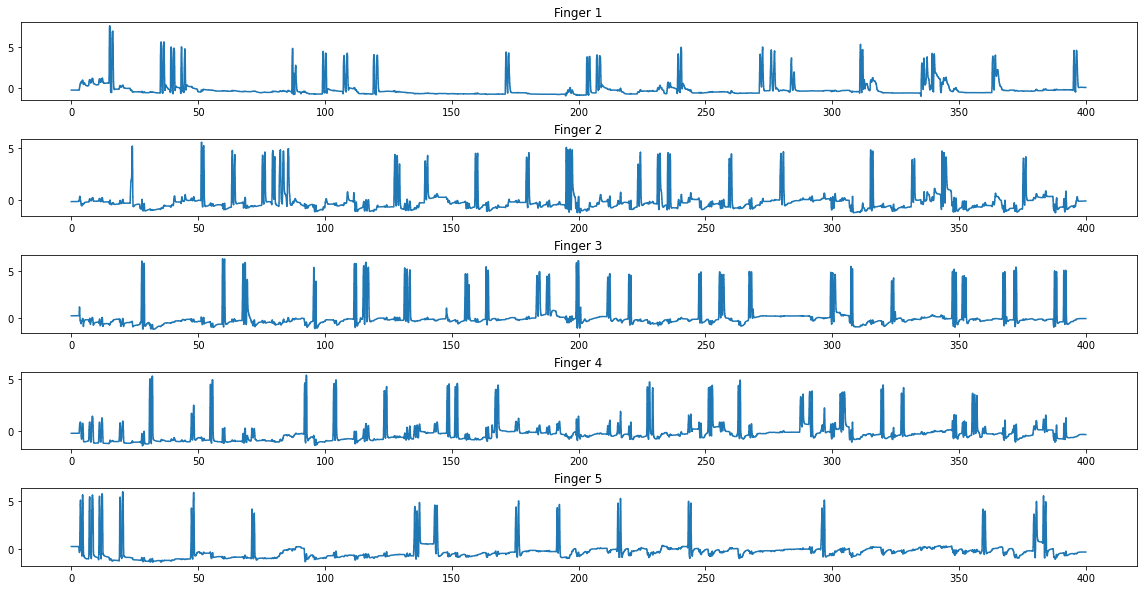

In [9]:
# Finger data plot :

plt.rcParams['figure.figsize'] = (20,10)
fig,ax = plt.subplots(5,1)
plt.subplots_adjust(hspace=0.5)
for i in range(5):
    ax[i].plot(time_space,finger_data[i])
    ax[i].set_title(f'Finger {i+1}')

In [45]:
# Check for bad channels : 

std_dev = np.std(channel_data,axis=1)
allowed_error = 10000
bad_channels = [ i + 1 for i in range(channels) if std_dev[i] > allowed_error ]

# plt.rcParams['figure.figsize'] = (20,6)
# plt.xticks(np.arange(min(channel_space),max(channel_space) + 1,1))
# plt.plot(channel_space,std_dev)
# print(bad_channels)

In [39]:
import mne

In [58]:
sampling_freq = 1000
channel_names = [ f'ECOG{n:02}' for n in range(1,channels+1) ]
info = mne.create_info(ch_names=channel_names,ch_types=['ecog']*channels,sfreq=sampling_freq) 
info['bads'] = [ f'ECOG{n:02}' for n in bad_channels ]
raw = mne.io.RawArray(channel_data, info)
good = mne.pick_types(raw.info,ecog=True) #Exclude bad channels
# raw.plot(n_channels=channels,scalings='auto',show_scrollbars=False)

Creating RawArray with float64 data, n_channels=62, n_times=400000
    Range : 0 ... 399999 =      0.000 ...   399.999 secs
Ready.


In [53]:
# High pass filter (5 Hz) to remove low frequency drift
raw_high = raw.copy().filter(5,200., None, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 1651 samples (1.651 sec)



In [57]:
# CAR mean re-referencing (Alternative : Median CAR (manual implementation))
raw = raw_high 
raw_CAR, ref_data = mne.set_eeg_reference(raw,copy=True)
# raw_CAR.plot(n_channels=channels,scalings='auto',show_scrollbars=False)

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.


In [56]:
# Remove line noise :
raw = raw_CAR  
base_freq = 60
freq_lim = 200
bad_freq = [ x for x in range(base_freq,freq_lim+1,base_freq) ]
raw_notch = raw.copy().notch_filter(freqs=bad_freq,picks=good) 
# raw_notch.plot_psd(picks=good, tmin=0, tmax=400, fmin=0, fmax=210, average=True, spatial_colors=False)
raw = raw_notch 


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

